# Final Notebook: Poisoning, Data Selection, and Pruning
**Comparing:** Full data, Random subset, EL2N, Forgettability, and CRAIG-approx selection methods.

This notebook runs prototype experiments on CIFAR-10 with label-flip and backdoor poisons, computes
attack success rate (ASR), poison retention, clean accuracy, and shows comparison plots.

**Usage:** Set `PROTOTYPE = True` for quick runs on Colab/GPU. For final experiments, set `PROTOTYPE=False` and
increase epochs and repetitions.


In [ ]:
# -------------------------
# Setup: installs, imports, reproducibility
# -------------------------
PROTOTYPE = True  # set False for full experiments

# Install optional packages if missing (scikit-learn, tqdm)
try:
    import sklearn, tqdm
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn", "tqdm"])

import os, random, time, copy, math
from pathlib import Path
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision, torchvision.transforms as transforms
from torchvision.models import resnet18
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

# reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Device:', device)

In [ ]:
# -------------------------
# Data transforms & load CIFAR-10
# -------------------------
if PROTOTYPE:
    train_epochs = 8
    batch_size = 128
    subset_frac = 0.25
    el2n_epochs = 2
    forget_epochs = 3
else:
    train_epochs = 100
    batch_size = 128
    subset_frac = 0.5
    el2n_epochs = 5
    forget_epochs = 10

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
])

data_root = './data'
train_set = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform_train)
test_set  = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform_test)

num_workers = 2
train_loader_full = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=True)
print('Loaded CIFAR-10: train size', len(train_set), 'test size', len(test_set))

Loaded CIFAR-10: train size 50000 test size 10000


In [ ]:
# -------------------------
# Poison generation: label-flip and backdoor
# -------------------------
import copy
from PIL import Image, ImageDraw

def make_label_flip_dataset(orig_dataset, fraction=0.01, source_class=0, target_class=1, seed=0):
    """
    Returns (copied_dataset, set_of_poisoned_indices)
    """
    random.seed(seed)
    ds = copy.deepcopy(orig_dataset)
    indices = [i for i,l in enumerate(ds.targets) if l==source_class]
    n_poison = max(1, int(len(indices) * fraction))
    poisoned_idx = random.sample(indices, n_poison)
    for i in poisoned_idx:
        ds.targets[i] = target_class
    return ds, set(poisoned_idx)

class BackdoorDataset(torchvision.datasets.CIFAR10):
    def __init__(self, *args, poison_frac=0.01, patch_size=6, source_class=None, target_class=0, seed=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.poison_frac = poison_frac
        self.patch_size = patch_size
        self.source_class = source_class
        self.target_class = target_class
        self.seed = seed
        random.seed(seed)
        if source_class is None:
            all_idx = list(range(len(self)))
            n_poison = max(1, int(len(all_idx) * poison_frac))
            self.poisoned_idx = set(random.sample(all_idx, n_poison))
        else:
            indices = [i for i,l in enumerate(self.targets) if l==source_class]
            n_poison = max(1, int(len(indices) * poison_frac))
            self.poisoned_idx = set(random.sample(indices, n_poison))

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        if index in self.poisoned_idx:
            raw = Image.fromarray(self.data[index])
            draw = ImageDraw.Draw(raw)
            w,h = raw.size
            ps = self.patch_size
            box = (w-ps-1, h-ps-1, w-1, h-1)
            draw.rectangle(box, fill=(255,0,0))
            if self.transform is not None:
                img = self.transform(raw)
            else:
                img = transforms.ToTensor()(raw)
            target = self.target_class
        return img, target

In [ ]:
# -------------------------
# Model wrapper: ResNet18 exposing features & classifier
# -------------------------
class ResNet18Wrapper(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        base = resnet18(pretrained=False)
        # keep everything up to avgpool as features
        self.features = nn.Sequential(*list(base.children())[:-1])  # ends with avgpool
        feat_dim = base.fc.in_features
        self.classifier = nn.Linear(feat_dim, num_classes)
        nn.init.normal_(self.classifier.weight, 0, 0.01)
        nn.init.constant_(self.classifier.bias, 0.0)
    def forward(self, x):
        f = self.features(x)              # (B, C, 1, 1)
        f = torch.flatten(f, 1)           # (B, feat_dim)
        return self.classifier(f)

def get_model(num_classes=10):
    return ResNet18Wrapper(num_classes=num_classes).to(device)

In [ ]:
# -------------------------
# Training / evaluation utilities
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion, desc=''):
    model.train()
    running_loss = 0.0; correct = 0; total = 0
    for inputs, targets in tqdm(loader, desc=desc, leave=False):
        inputs = inputs.to(device); targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward(); optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0); correct += predicted.eq(targets).sum().item()
    return running_loss/total, correct/total

def evaluate(model, loader):
    model.eval()
    total=0; correct=0; losses=0.0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device); targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0); correct += predicted.eq(targets).sum().item()
    return losses/total, correct/total

def predict_logits(model, loader):
    model.eval()
    logits_list = []; targets_list = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            logits = model(inputs)
            logits_list.append(logits.cpu()); targets_list.append(targets)
    return torch.cat(logits_list), torch.cat(targets_list)


In [ ]:
# -------------------------
# EL2N and Forgetting scores
# -------------------------
def compute_el2n(model_fn, dataset, epochs=3, batch_size=256):
    model = model_fn().to(device)
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    el2n = np.zeros(len(dataset))
    loader_train = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=num_workers)
    for e in range(epochs):
        print('EL2N train epoch', e+1)
        train_one_epoch(model, loader_train, opt, criterion, desc=f'EL2N-{e}')
        idx = 0
        model.eval()
        with torch.no_grad():
            for inputs, targets in DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers):
                inputs = inputs.to(device)
                logits = model(inputs).cpu().numpy()
                bs = logits.shape[0]
                for i in range(bs):
                    lab = np.zeros(logits.shape[1]); lab[targets[i]] = 1.0
                    el2n[idx+i] += np.linalg.norm(logits[i] - lab)
                idx += bs
    el2n = el2n / epochs
    return el2n

def compute_forgetting_scores(model_fn, dataset, epochs=5, batch_size=256):
    model = model_fn().to(device)
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    n = len(dataset)
    correct_counts = np.zeros(n, dtype=int)
    for e in range(epochs):
        print('Forgetting training epoch', e+1)
        train_one_epoch(model, DataLoader(dataset, batch_size=128, shuffle=True, num_workers=num_workers), opt, criterion, desc=f'Forget-{e}')
        idx = 0
        model.eval()
        with torch.no_grad():
            for inputs, targets in DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers):
                inputs = inputs.to(device)
                outputs = model(inputs).cpu().numpy()
                preds = outputs.argmax(axis=1)
                bs = len(preds)
                for i in range(bs):
                    if preds[i] == targets.numpy()[i]:
                        correct_counts[idx+i] += 1
                idx += bs
    forgetting = epochs - correct_counts
    return forgetting

In [ ]:
# -------------------------
# CRAIG: last-layer gradient embeddings + facility-location greedy
# -------------------------
import torch.nn.functional as F

def get_last_layer_grads_wrapper(model, dataset, batch_size=256):
    """
    Returns numpy array shape (N, D) of last-layer gradient embeddings
    for every example in dataset. The dataset is assumed to be ordered
    so index i corresponds to embeddings[i].
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model.eval()
    embeddings = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device); labels = labels.to(device)
            feats = model.features(imgs)           # (B, C, 1, 1)
            feats = torch.flatten(feats, 1)        # (B, feat_dim)
            logits = model.classifier(feats)       # (B, num_classes)
            probs = torch.softmax(logits, dim=1)
            y_onehot = torch.zeros_like(probs)
            y_onehot[torch.arange(len(labels)), labels] = 1.0
            diff = (probs - y_onehot)              # (B, num_classes)
            emb = torch.einsum('bc,bd->bcd', diff, feats).reshape(len(labels), -1)  # (B, num_classes * feat_dim)
            embeddings.append(emb.cpu())
    embeddings = torch.cat(embeddings, dim=0)  # (N, D)
    return embeddings.numpy()

def facility_location_greedy(embeddings, k):
    """
    Facility-location greedy selection on normalized embeddings.
    embeddings: (N, D) numpy
    returns: selected indices (list)
    """
    N = embeddings.shape[0]
    # normalize for numerical stability
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-10
    E = embeddings / norms
    S = E @ E.T  # similarity matrix, shape (N, N)
    selected = []
    max_sim = np.zeros(N)   # current best similarity of each point to any selected so far
    for _ in range(k):
        # gain of picking candidate i = sum( max( S[i,:], max_sim ) - max_sim )
        # compute approximate marginal gains by checking S.max - max_sim
        gains = S.max(axis=0) - max_sim   # cheap approx
        idx = int(np.argmax(gains))
        selected.append(idx)
        max_sim = np.maximum(max_sim, S[idx])
    return selected

def select_subset_craig(model_fn, full_dataset, subset_size, batch_size=256):
    """
    model_fn: function returning a fresh model instance (so embeddings computed on fresh model)
    full_dataset: dataset to select from (ordered)
    subset_size: int
    """
    model = model_fn().to(device)
    print('Computing CRAIG embeddings (last-layer grads)...')
    emb = get_last_layer_grads_wrapper(model, full_dataset, batch_size=batch_size)
    print('Selecting with facility-location greedy ...')
    sel = facility_location_greedy(emb, subset_size)
    print(f'CRAIG selected {len(sel)} items.')
    return sel

In [ ]:
import torch
from torch.utils.data import Subset

def distributed_greedy_craig(model_fn, full_dataset, subset_size, partitions=5, batch_size=256):
    print(f'Distributed CRAIG: dataset size {len(full_dataset)}, partitions {partitions}, total subset size {subset_size}')

    partition_size = len(full_dataset) // partitions
    local_subsets = []
    local_k = subset_size // partitions

    for i in range(partitions):
        start = i * partition_size
        end = (i + 1) * partition_size if i < partitions - 1 else len(full_dataset)
        local_indices = list(range(start, end))
        local_data = Subset(full_dataset, local_indices)

        print(f'Partition {i+1}/{partitions}: computing embeddings for {len(local_data)} samples...')
        model = model_fn().to(device)
        emb = get_last_layer_grads_wrapper(model, local_data, batch_size=batch_size)

        print(f'Partition {i+1}/{partitions}: running facility-location greedy selection for {local_k} samples...')
        local_sel = facility_location_greedy(emb, local_k)

        local_sel_global = [local_indices[idx] for idx in local_sel]
        local_subsets.extend(local_sel_global)

    print(f'Final selection: computing embeddings for combined local subset of size {len(local_subsets)}...')
    combined_data = Subset(full_dataset, local_subsets)
    model = model_fn().to(device)
    emb = get_last_layer_grads_wrapper(model, combined_data, batch_size=batch_size)

    print(f'Final selection: running facility-location greedy for final {subset_size} samples...')
    final_sel_local = facility_location_greedy(emb, subset_size)

    final_sel_global = [local_subsets[idx] for idx in final_sel_local]
    print(f'Distributed CRAIG finished selecting {len(final_sel_global)} samples.')

    return final_sel_global


In [ ]:
# -------------------------
# Subset helpers and metrics: ASR, retention
# -------------------------
def subset_from_indices(dataset, indices):
    return Subset(dataset, indices)

def sample_random_indices(dataset, k, seed=0):
    random.seed(seed); idxs = list(range(len(dataset))); return random.sample(idxs, k)

def compute_poison_retention(poisoned_idx_set, subset_indices):
    kept = sum([1 for i in subset_indices if i in poisoned_idx_set])
    return kept, len(poisoned_idx_set), kept / max(1, len(poisoned_idx_set))

def compute_backdoor_asr(model, test_loader, trigger_patch_size=6, target_label=0):
    model.eval(); total=0; succ=0
    mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(1,3,1,1).to(device)
    std  = torch.tensor((0.2470, 0.2435, 0.2616)).view(1,3,1,1).to(device)
    with torch.no_grad():
        for inputs, targets in test_loader:
            imgs = inputs.clone().to(device)
            imgs = imgs * std + mean
            imgs[:, :, (32-trigger_patch_size):, (32-trigger_patch_size):] = torch.tensor([1.0, 0.0, 0.0]).view(1,3,1,1).to(device)
            imgs = (imgs - mean) / std
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu().numpy()
            total += len(preds)
            succ += (preds == target_label).sum().item()
    return succ / total

def compute_labelflip_asr(model, test_loader, source_label=0, target_label=1):
    model.eval(); total=0; succ=0
    with torch.no_grad():
        for inputs, targets in test_loader:
            mask = (targets == source_label)
            if mask.sum() == 0: continue
            batch = inputs[mask].to(device)
            outputs = model(batch)
            preds = outputs.argmax(dim=1).cpu().numpy()
            total += len(preds)
            succ += (preds == target_label).sum().item()
    return succ / total if total>0 else 0.0

In [ ]:
# -------------------------
# Pruning utilities (IMP) with rewind
# -------------------------
def flatten_all_weights(model):
    return torch.cat([p.data.view(-1).abs().cpu() for p in model.parameters() if p.requires_grad])

def prune_by_percentile(model, amount):
    all_weights = flatten_all_weights(model)
    k = int(len(all_weights) * amount)
    if k < 1:
        threshold = -1.0
    else:
        try:
            threshold = all_weights.kthvalue(k).values.item()
        except Exception:
            threshold = float(np.quantile(all_weights.numpy(), k/len(all_weights)))
    mask = {}
    for name, p in model.named_parameters():
        if p.requires_grad:
            mask[name] = (p.data.abs().cpu() > threshold).float()
    return mask

def apply_mask(model, mask):
    for name, p in model.named_parameters():
        if name in mask:
            p.data.mul_(mask[name].to(p.device))

def iterative_magnitude_prune_and_retrain(model_fn, train_dataset, test_loader, fraction_to_prune=0.2, iterations=2, rewind_epoch=1, epochs_per_cycle=3):
    model = model_fn().to(device)
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    crit = nn.CrossEntropyLoss()
    # initial training to get rewind_state
    for e in range(rewind_epoch):
        train_one_epoch(model, DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers), opt, crit, desc=f'Rewind{e}')
    rewind_state = copy.deepcopy(model.state_dict())
    current_model = model
    mask = None
    for it in range(iterations):
        mask = prune_by_percentile(current_model, fraction_to_prune)
        apply_mask(current_model, mask)
        # rewind weights then reapply mask
        current_model.load_state_dict(rewind_state)
        apply_mask(current_model, mask)
        opt = optim.SGD(current_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        for e in range(epochs_per_cycle):
            train_one_epoch(current_model, DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers), opt, crit, desc=f'Prune{it}-E{e}')
    return current_model, mask

In [ ]:
# -------------------------
# Orchestrate all methods and evaluate
# -------------------------
def run_all_methods(poison_type='backdoor', poison_frac=0.02, subset_frac=0.25, selection_methods=None):
    if selection_methods is None:
        selection_methods = ['full', 'random', 'el2n', 'forget', 'craig']
    results = {}
    # prepare poisoned dataset
    if poison_type == 'label_flip':
        ds_poisoned, poisoned_idx = make_label_flip_dataset(train_set, fraction=poison_frac, source_class=0, target_class=1, seed=seed)
        poisoned_set = poisoned_idx
    elif poison_type == 'backdoor':
        ds_poisoned = BackdoorDataset(root=data_root, train=True, download=False, transform=transform_train,
                                     poison_frac=poison_frac, patch_size=6, source_class=None, target_class=0, seed=seed)
        poisoned_set = ds_poisoned.poisoned_idx
    else:
        raise ValueError('Unknown poison type')
    n = len(ds_poisoned); k = int(n * subset_frac)
    print(f'Running poison_type={poison_type}, poison_frac={poison_frac}, subset size {k} (of {n})')
    for method in selection_methods:
        print('\n---- Selection method:', method, '----')
        if method == 'full':
            indices = list(range(n))
        elif method == 'random':
            indices = sample_random_indices(ds_poisoned, k, seed=seed)
        elif method == 'el2n':
            scores = compute_el2n(lambda: get_model(), ds_poisoned, epochs=el2n_epochs)
            idx_sorted = np.argsort(-scores)  # keep hardest
            indices = idx_sorted[:k].tolist()
        elif method == 'forget':
            scores = compute_forgetting_scores(lambda: get_model(), ds_poisoned, epochs=forget_epochs)
            idx_sorted = np.argsort(-scores)
            indices = idx_sorted[:k].tolist()
        elif method == 'craig_dist':
            indices = distributed_greedy_craig(
                model_fn=lambda: get_model(),
                full_dataset=ds_poisoned,
                subset_size=k,
                partitions=5,
                batch_size=256
            )
        elif method == 'craig':
            indices = select_subset_craig(lambda: get_model(), ds_poisoned, subset_size=k, batch_size=256)
        else:
            raise ValueError('Unknown method ' + method)
        subset = subset_from_indices(ds_poisoned, indices)
        # train model on subset
        model = get_model()
        opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        crit = nn.CrossEntropyLoss()
        for e in range(train_epochs):
            train_one_epoch(model, DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=num_workers), opt, crit, desc=f'{method}-Train-E{e}')
        loss, acc = evaluate(model, test_loader)
        print('Clean test acc after training on subset:', acc)
        # compute ASR
        if poison_type == 'backdoor':
            asr = compute_backdoor_asr(model, test_loader, trigger_patch_size=6, target_label=0)
        else:
            asr = compute_labelflip_asr(model, test_loader, source_label=0, target_label=1)
        kept, total_poison, retention = compute_poison_retention(poisoned_set, indices)
        print(f'Kept poisoned examples in subset: {kept}/{total_poison} ({retention*100:.2f}%)')
        print('ASR (attack success rate):', asr)
        # prune & evaluate
        pruned_model, mask = iterative_magnitude_prune_and_retrain(lambda: get_model(), subset, test_loader,
                                                                   fraction_to_prune=0.2, iterations=1, rewind_epoch=1, epochs_per_cycle=3)
        ploss, pacc = evaluate(pruned_model, test_loader)
        if poison_type == 'backdoor':
            pasr = compute_backdoor_asr(pruned_model, test_loader, trigger_patch_size=6, target_label=0)
        else:
            pasr = compute_labelflip_asr(pruned_model, test_loader, source_label=0, target_label=1)
        print('Pruned model acc:', pacc, 'Pruned ASR:', pasr)
        results[method] = {'subset_size': len(indices),
                           'clean_acc': acc,
                           'asr': asr,
                           'poison_kept': kept,
                           'poison_total': total_poison,
                           'poison_retention': retention,
                           'pruned_acc': pacc,
                           'pruned_asr': pasr}
    return results

In [ ]:
# -------------------------
# Plotting and CSV save helpers
# -------------------------
def plot_results(results, title='Results'):
    methods = list(results.keys())
    clean = [results[m]['clean_acc'] for m in methods]
    asr = [results[m]['asr'] for m in methods]
    retention = [results[m]['poison_retention'] for m in methods]
    pruned_acc = [results[m]['pruned_acc'] for m in methods]
    pruned_asr = [results[m]['pruned_asr'] for m in methods]

    x = np.arange(len(methods))
    width = 0.28
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.bar(x - width, clean, width, label='Clean Acc')
    plt.bar(x, pruned_acc, width, label='Pruned Acc')
    plt.xticks(x, methods, rotation=30)
    plt.ylabel('Accuracy'); plt.ylim(0,1); plt.legend()
    plt.title('Clean Acc (Dense vs Pruned)')

    plt.subplot(1,2,2)
    plt.bar(x - width, asr, width, label='ASR (dense)')
    plt.bar(x, pruned_asr, width, label='ASR (pruned)')
    plt.xticks(x, methods, rotation=30)
    plt.ylabel('Attack Success Rate'); plt.ylim(0,1); plt.legend()
    plt.title('Attack Success Rate (Dense vs Pruned)')
    plt.suptitle(title)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    plt.figure(figsize=(6,3))
    plt.bar(methods, retention)
    plt.title('Poison Retention Fraction in Selected Subsets')
    plt.ylim(0,1)
    plt.show()

def save_results_csv(results, fname='results_summary.csv'):
    rows = []
    for m,v in results.items():
        r = {'method': m}
        r.update(v)
        rows.append(r)
    df = pd.DataFrame(rows)
    df.to_csv(fname, index=False)
    print('Saved results to', fname)

Running poison_type=backdoor, poison_frac=0.02, subset size 12500 (of 50000)

---- Selection method: full ----


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Clean test acc after training on subset: 0.6573
Kept poisoned examples in subset: 1000/1000 (100.00%)
ASR (attack success rate): 0.9999


Pruned model acc: 0.5824 Pruned ASR: 0.998

---- Selection method: random ----


Clean test acc after training on subset: 0.4804
Kept poisoned examples in subset: 991/1000 (99.10%)
ASR (attack success rate): 0.9998


Pruned model acc: 0.4308 Pruned ASR: 0.9969

---- Selection method: el2n ----
EL2N train epoch 1


EL2N train epoch 2


Clean test acc after training on subset: 0.4739
Kept poisoned examples in subset: 681/1000 (68.10%)
ASR (attack success rate): 0.9989


Pruned model acc: 0.3868 Pruned ASR: 0.9922

---- Selection method: forget ----
Forgetting training epoch 1


Forgetting training epoch 2


Forgetting training epoch 3


Clean test acc after training on subset: 0.242
Kept poisoned examples in subset: 24/1000 (2.40%)
ASR (attack success rate): 0.1291


Pruned model acc: 0.1981 Pruned ASR: 0.0417

---- Selection method: craig_dist ----
Distributed CRAIG: dataset size 50000, partitions 5, total subset size 12500
Partition 1/5: computing embeddings for 10000 samples...
Partition 1/5: running facility-location greedy selection for 2500 samples...
Partition 2/5: computing embeddings for 10000 samples...
Partition 2/5: running facility-location greedy selection for 2500 samples...
Partition 3/5: computing embeddings for 10000 samples...
Partition 3/5: running facility-location greedy selection for 2500 samples...
Partition 4/5: computing embeddings for 10000 samples...
Partition 4/5: running facility-location greedy selection for 2500 samples...
Partition 5/5: computing embeddings for 10000 samples...
Partition 5/5: running facility-location greedy selection for 2500 samples...
Final selection: computing embeddings for combined local subset of size 12500...
Final selection: running facility-location greedy for final 12500 samples...
Distri

Clean test acc after training on subset: 0.4354
Kept poisoned examples in subset: 311/1000 (31.10%)
ASR (attack success rate): 0.9902


Pruned model acc: 0.3828 Pruned ASR: 0.0784

Backdoor results:
{'full': {'subset_size': 50000, 'clean_acc': 0.6573, 'asr': 0.9999, 'poison_kept': 1000, 'poison_total': 1000, 'poison_retention': 1.0, 'pruned_acc': 0.5824, 'pruned_asr': 0.998}, 'random': {'subset_size': 12500, 'clean_acc': 0.4804, 'asr': 0.9998, 'poison_kept': 991, 'poison_total': 1000, 'poison_retention': 0.991, 'pruned_acc': 0.4308, 'pruned_asr': 0.9969}, 'el2n': {'subset_size': 12500, 'clean_acc': 0.4739, 'asr': 0.9989, 'poison_kept': 681, 'poison_total': 1000, 'poison_retention': 0.681, 'pruned_acc': 0.3868, 'pruned_asr': 0.9922}, 'forget': {'subset_size': 12500, 'clean_acc': 0.242, 'asr': 0.1291, 'poison_kept': 24, 'poison_total': 1000, 'poison_retention': 0.024, 'pruned_acc': 0.1981, 'pruned_asr': 0.0417}, 'craig_dist': {'subset_size': 12500, 'clean_acc': 0.4354, 'asr': 0.9902, 'poison_kept': 311, 'poison_total': 1000, 'poison_retention': 0.311, 'pruned_acc': 0.3828, 'pruned_asr': 0.0784}}


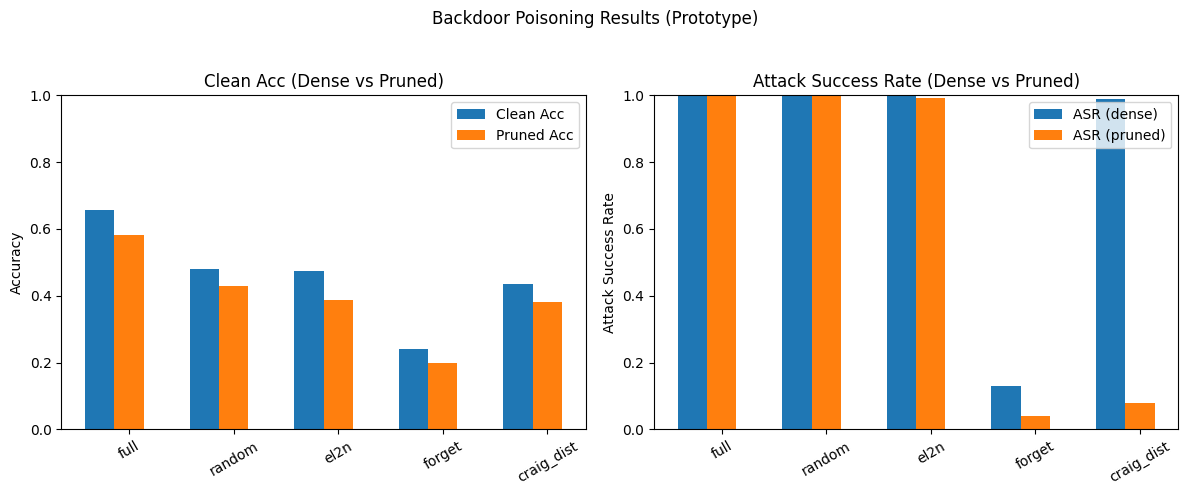

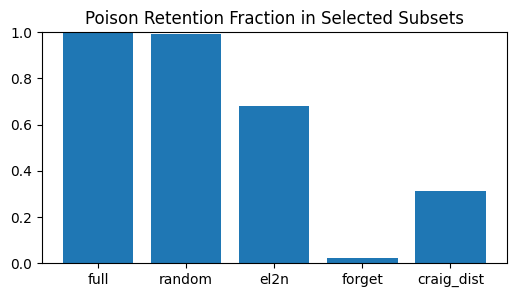

Saved results to backdoor_results_prototype.csv


In [ ]:
# -------------------------
# Example prototype run
# -------------------------
if __name__ == '__main__':
    selection_methods = ['full', 'random', 'el2n', 'forget', 'craig_dist']
    # Backdoor experiment
    res_backdoor = run_all_methods(poison_type='backdoor', poison_frac=0.02, subset_frac=subset_frac, selection_methods=selection_methods)
    print('\nBackdoor results:'); print(res_backdoor)
    plot_results(res_backdoor, title='Backdoor Poisoning Results (Prototype)')
    save_results_csv(res_backdoor, fname='backdoor_results_prototype.csv')

    # Optional: run label-flip (uncomment to run)
    # res_labelflip = run_all_methods(poison_type='label_flip', poison_frac=0.02, subset_frac=subset_frac, selection_methods=selection_methods)
    # print('\nLabel-flip results:'); print(res_labelflip)
    # plot_results(res_labelflip, title='Label-Flip Poisoning Results (Prototype)')
    # save_results_csv(res_labelflip, fname='labelflip_results_prototype.csv')


## Notes & next steps

- For final experiments: set `PROTOTYPE=False`, increase `train_epochs`, `el2n_epochs`, and `forget_epochs`, and run multiple random seeds.
- Replace CRAIG-approx with the official CRAIG implementation (gradient-matching) for stronger comparisons (Done).
- Add more powerful poisoning attacks (gradient-matching poison) for robustness testing.
- Save results to CSV and run multiple seeds for statistical significance.
